# Data Preparation

In [1]:
import pandas as pd
import numpy as np
from matplotlib        import pyplot
from matplotlib.pyplot import figure

import warnings
warnings.filterwarnings("ignore")

In [2]:
#path = "C:/temp/DSC_Project/Data/"
path = "C:/Users/aahuile/Documents/GitHub/DSC_Project/"
#path = "C:/Users/sbeyer/Documents/GitHub/DSC_Project/"
#path = "C:/Users/sdam/Documents/GitHub/DSC_Project/"
#path = "C:/Users/pborchert/Documents/GitHub/DSC_Project/"
#path = "C:/Users/evrijghem/Documents/GitHub/DSC_Project/"

#Import CSV files
gifts        = pd.read_csv(path + "gifts.csv", sep=";")
donors       = pd.read_csv(path + "donors.csv", sep=";")
camp13       = pd.read_csv(path + "campaign20130411.csv", sep=";")
camp14       = pd.read_csv(path + "campaign20140115.csv", sep=";")
region_codes = pd.read_csv(path + "region_codes_belgium.csv", sep=";")

# Preparing the data

In [3]:
#Cleaning Gifts column
gifts["date"] = pd.to_datetime(gifts["date"], format="%d/%m/%Y")

In [4]:
#Outlier function definition
outliers=[]
def detect_outlier(data_1,col1):
    
    threshold=3
    mean_1 = np.mean(data_1[col1])
    std_1 =np.std(data_1[col1])
    
    
    for y in data_1[col1]:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

#Select minimum outlier
min_amt = min(detect_outlier(gifts,"amount"))
#replace outliers bigger than the threshold value (minimum outlier) by the minimum outlier
gifts.loc[gifts['amount']>min_amt,'amount']=min_amt

In [5]:
#Remove the region column, since we'll only be using provinces
donors = donors.drop(columns=["region"])

In [6]:
from datetime import datetime
from pandasql import sqldf

#selecting the year from the gifts table needed for further analysis
gifts['year'] = gifts['date'].dt.year

#use sql to create a new test and training set from the gifts and donor table
pysqldf = lambda q: sqldf(q, globals())
dsc= pysqldf("""
SELECT c.*,d.gender,d.language,d.zipcode,
        max(gf.amount) as max_gift, min(gf.amount) as min_gift,
        avg(gf.amount) as mean_gift, min(gf.year) as first_gift,max(gf.year) as last_gift,
        count(gf.year) as n_gifts, ((max(gf.date)-min(gf.date))*365)/count(gf.year) as avg_datediff,
        max(case when gf.date<'2012-01-01' then 1 else 0 end) dormant_flag,
        max(case when gf.campid=0 then 1 else 0 end) no_camp_flag
FROM camp13 c
    left join donors d on d.donorid=c.donorid 
    left join gifts gf on gf.donorid=c.donorid and gf.date<'2013-01-01'
GROUP BY 1,2,3,4,5
""")

dsc_train= pysqldf("""
SELECT c.*,d.gender,d.language,d.zipcode,max(gf.amount) as max_gift, min(gf.amount) as min_gift,
        avg(gf.amount) as mean_gift, min(gf.year) as first_gift,max(gf.year) as last_gift,
        count(gf.year) as n_gifts, ((max(gf.date)-min(gf.date))*365)/count(gf.year) as avg_datediff,
        max(case when gf.date<'2013-01-01' then 1 else 0 end) dormant_flag,
        max(case when gf.campid=0 then 1 else 0 end) no_camp_flag
FROM camp14 c
    left join donors d on d.donorid=c.donorid 
    left join gifts gf on gf.donorid=c.donorid and gf.date<'2013-01-01'
GROUP BY 1,2,3,4,5
""")

In [7]:
#Cleaning Zip Codes
#Region_codes table create start and end bracket
region_codes[["Zip_start", "Zip_end"]] = region_codes["Zipcode"].str.split("?", n = 2, expand = True)
region_codes = region_codes.drop(columns=["Zipcode"])
region_codes.Zip_start = region_codes.Zip_start.astype(int)
region_codes.Zip_end = region_codes.Zip_end.astype(int)

# Convert Non numeric to NA values
dsc["zipcode"] = dsc["zipcode"].str.replace('[^0-9]', "0")
dsc_train["zipcode"] = dsc_train["zipcode"].str.replace('[^0-9]', "0")

dsc.loc[dsc["zipcode"].isna(),"zipcode"] = 0
dsc_train.loc[dsc_train["zipcode"].isna(),"zipcode"] = 0

In [8]:
#Assign Column Province in dsc
#Create aux table
aux = pysqldf("""
SELECT d.zipcode,r.province
FROM dsc d
JOIN region_codes r
WHERE d.zipcode between r.zip_start and r.zip_end
GROUP BY 1
    UNION
        SELECT d.zipcode,r.province
        FROM dsc_train d
        JOIN region_codes r
        WHERE d.zipcode between r.zip_start and r.zip_end
        GROUP BY 1
""")
#using pandas merge join the aux table with te dsc table
dsc = pd.merge(dsc,aux,how='left',left_on='zipcode',right_on='zipcode')
#replacing NA values with O
dsc.loc[dsc["Province"].isna(),"Province"] = "0"
#Duplication of the previous commands for the train dataset
dsc_train = pd.merge(dsc_train,aux,how='left',left_on='zipcode',right_on='zipcode')
dsc_train.loc[dsc_train["Province"].isna(),"Province"] = "0"

In [9]:
#Creating dummies for the province variable in both tables
prov_set = pd.get_dummies(dsc["Province"])
prov_t_set = pd.get_dummies(dsc_train["Province"])

#replace column 0 by prov_missing to indicate when the province was not specified
prov_set.rename(columns={"0": "Missing"},inplace=True)
prov_set = prov_set.add_prefix('prov_')
prov_t_set.rename(columns={"0": "Missing"},inplace=True)
prov_t_set = prov_t_set.add_prefix('prov_')

#merge the province datatables with the dsc data tables
dsc = pd.concat([dsc, prov_set], axis=1, join='inner')
dsc_train = pd.concat([dsc_train, prov_set], axis=1, join='inner')

In [10]:
dsc_seg = pysqldf("""
select *, case when last_gift < 2011 and mean_gift > 20 and max_gift > 35 then "inactive" else "active" end as segment
from dsc d
""")
ina = dsc_seg[dsc_seg["amount"] >= 35].groupby("segment").count()
ones = ina.iloc[1,0]
a = dsc_seg[dsc_seg["amount"] < 35].groupby("segment").count()
zeros = a.iloc[1,0]
print((ones/zeros)*100, "%")
print((516 / 34375)*100, "%")
print(zeros)

2.2154963680387407 %
1.501090909090909 %
8260


In [11]:
gg = dsc_seg[dsc_seg["amount"] >= 35]
print(gg.describe())
gg2 = dsc_seg[dsc_seg["amount"] < 35]
print(gg2.describe())

             donorID      amount    max_gift    min_gift   mean_gift  \
count     516.000000  516.000000  516.000000  516.000000  516.000000   
mean   119917.951550   47.991996   36.821221   26.593760   31.185220   
std     12570.073125   27.107563   23.000031   15.128755   16.827434   
min    100126.000000   39.000000    5.000000    2.480000    5.000000   
25%    109088.250000   40.000000   30.000000   24.790000   24.790000   
50%    118665.000000   41.000000   32.250000   24.790000   30.000000   
75%    130727.250000   50.000000   40.000000   30.000000   34.753250   
max    144624.000000  476.870000  174.620000  174.620000  174.620000   

        first_gift    last_gift     n_gifts  avg_datediff  dormant_flag  ...  \
count   516.000000   516.000000  516.000000    516.000000         516.0  ...   
mean   2002.527132  2006.009690    4.482558    226.168605           1.0  ...   
std       5.037070     4.389518    6.128850    298.064639           0.0  ...   
min    1995.000000  1995.000000

In [12]:
#Clean DSC last_gift, first_gift column (replace NA with mean)
dsc.loc[dsc["last_gift"].isna(),"last_gift"] = dsc.loc[dsc["last_gift"].notna(),"last_gift"].mean()
dsc["last_gift"] = dsc["last_gift"].astype(int)
dsc["last_gift"] = 2013 - dsc["last_gift"]

dsc.loc[dsc["first_gift"].isna(),"first_gift"] = dsc.loc[dsc["first_gift"].notna(),"first_gift"].mean()
dsc["first_gift"] = dsc["first_gift"].astype(int)
dsc["first_gift"] = 2013 - dsc["first_gift"]

#Clean DSC n_gifts column (Type to int)
dsc.n_gifts = dsc.n_gifts.astype(int)

#same for the dsc_train dataset
dsc_train.loc[dsc_train["last_gift"].isna(),"last_gift"] = dsc_train.loc[dsc_train["last_gift"].notna(),"last_gift"].mean()
dsc_train["last_gift"] = dsc_train["last_gift"].astype(int)
dsc_train["last_gift"] = 2014 - dsc_train["last_gift"]

dsc_train.loc[dsc_train["first_gift"].isna(),"first_gift"] = dsc_train.loc[dsc_train["first_gift"].notna(),"first_gift"].mean()
dsc_train["first_gift"] = dsc_train["first_gift"].astype(int)
dsc_train["first_gift"] = 2014 - dsc_train["first_gift"]

dsc_train.n_gifts = dsc_train.n_gifts.astype(int)

In [13]:
#Clean DSC max_gift, min_gift, mean_gift (replace NA with mean)
dsc.loc[dsc["max_gift"].isna(),"max_gift"] = dsc.loc[dsc["max_gift"].notna(),"max_gift"].mean()
dsc["max_gift"] = dsc["max_gift"].astype(float)

dsc.loc[dsc["min_gift"].isna(),"min_gift"] = dsc.loc[dsc["min_gift"].notna(),"min_gift"].mean()
dsc["min_gift"] = dsc["min_gift"].astype(float)

dsc.loc[dsc["mean_gift"].isna(),"mean_gift"] = dsc.loc[dsc["mean_gift"].notna(),"mean_gift"].mean()
dsc["mean_gift"] = dsc["mean_gift"].astype(float)

#same for the dsc_train dataset
dsc_train.loc[dsc_train["max_gift"].isna(),"max_gift"] = dsc_train.loc[dsc_train["max_gift"].notna(),"max_gift"].mean()
dsc_train["max_gift"] = dsc_train["max_gift"].astype(float)

dsc_train.loc[dsc_train["min_gift"].isna(),"min_gift"] = dsc_train.loc[dsc_train["min_gift"].notna(),"min_gift"].mean()
dsc_train["min_gift"] = dsc_train["min_gift"].astype(float)

dsc_train.loc[dsc_train["mean_gift"].isna(),"mean_gift"] = dsc_train.loc[dsc_train["mean_gift"].notna(),"mean_gift"].mean()
dsc_train["mean_gift"] = dsc_train["mean_gift"].astype(float)

In [14]:
#replace NA values with 0 for both datasets
dsc.loc[dsc["avg_datediff"].isna(),"avg_datediff"] = 0
dsc_train.loc[dsc_train["avg_datediff"].isna(),"avg_datediff"] = 0

In [15]:
#rename gender types for both datasets
dictionary = {"M": "Male", "F": "Female", "C": "Couple", "S": "SoHo", "U": "Unknown"}
dsc = dsc.replace({"gender": dictionary})
dsc_train = dsc_train.replace({"gender": dictionary})

#Create dummies for the gender variable, add "gender_"
gend_set = pd.get_dummies(dsc["gender"])
gend_set = gend_set.add_prefix('gender_')
gend_t_set = pd.get_dummies(dsc_train["gender"])
gend_t_set = gend_t_set.add_prefix('gender_')

#add gender to both datasets 
dsc = pd.concat([dsc, gend_set], axis=1, join='inner')
dsc_train = pd.concat([dsc_train, gend_t_set], axis=1, join='inner')

In [16]:
#Create dummies for the language variable
dictionary = {"N": 1, "F": 0}
dsc = dsc.replace({"language": dictionary})
dsc_train = dsc_train.replace({"language": dictionary})

In [17]:
#Binary y-variable for models which reflects the threshold value of a gift of 35
dsc['y'] = (dsc["amount"] >= 35) * 1
dsc_train['y'] = (dsc_train["amount"] >= 35) * 1

In [18]:
dsc_copy = dsc.copy()

In [19]:
#Dropping redundant or non_usable columns
dsc.drop(columns=['Province','zipcode','prov_Missing','gender_Unknown','gender','donorID'],axis=1,inplace=True)
dsc_train.drop(columns=['Province','zipcode','prov_Missing','gender_Unknown','gender','donorID'], axis=1, inplace=True)

In [20]:
#Splitting train set for validation
from sklearn.model_selection import train_test_split

X = dsc_train[dsc_train.columns[~dsc_train.columns.isin(['y','mean_gift'])]]
y = dsc_train[['y']]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, stratify = y)

In [21]:
# from sklearn.preprocessing import StandardScaler
# X2 = X.loc[:,['max_gift', 'min_gift', 'first_gift','mean_gift',
#       'last_gift', 'n_gifts', 'avg_datediff']].values
# scaler = StandardScaler()
# X3 = scaler.fit_transform(X2)
# X[['max_gift', 'min_gift', 'first_gift','mean_gift',
#        'last_gift', 'n_gifts', 'avg_datediff']] = X3
# X.head()

# from sklearn.preprocessing import scale
# X2 = X.loc[:,['max_gift', 'min_gift', 'first_gift','mean_gift',
#       'last_gift', 'n_gifts', 'avg_datediff']].values
# X3 = scale(X2)
# X[['max_gift', 'min_gift', 'first_gift','mean_gift',
#        'last_gift', 'n_gifts', 'avg_datediff']] = X3
# X.head()

X2 = np.log(X.loc[:,['max_gift', 'min_gift', 'first_gift','mean_gift',
      'last_gift', 'n_gifts', 'avg_datediff']]+1)
X[['max_gift', 'min_gift', 'first_gift','mean_gift',
       'last_gift', 'n_gifts', 'avg_datediff']] = X2

# X2 = normalize(np.log(X.loc[:,['max_gift', 'min_gift', 'first_gift','mean_gift',
#       'last_gift', 'n_gifts', 'avg_datediff']]+1))
# X[['max_gift', 'min_gift', 'first_gift','mean_gift',
#        'last_gift', 'n_gifts', 'avg_datediff']] = X2

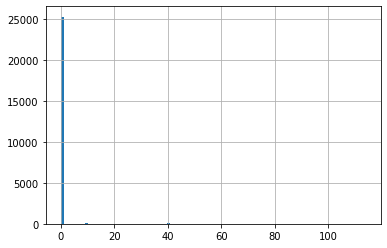

In [22]:
dsc_train['amount'].hist(bins=100)

In [23]:
#upsampling observations with amount > 35 in training Set

from sklearn.utils import resample

df_majority = dsc_train[dsc_train.y==0]
df_minority = dsc_train[dsc_train.y==1]
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=51,    # to match majority class
                                 random_state=123)
df_upsampled = pd.concat([dsc_train, df_minority_upsampled])

y = df_upsampled.y
X = df_upsampled.drop('y', axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, stratify=y)

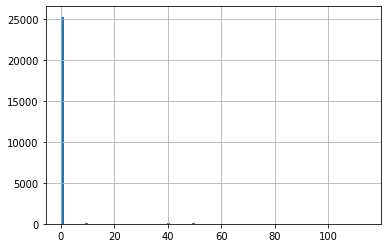

In [24]:
df_upsampled["amount"].hist(bins=100)

# Model Building

In [25]:
from sklearn.linear_model    import LogisticRegression
from sklearn.linear_model    import LinearRegression
from sklearn.linear_model    import Ridge
from sklearn.linear_model    import Lasso
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import GradientBoostingClassifier
from sklearn.svm             import SVC
from sklearn.neural_network  import MLPClassifier
from sklearn.neural_network  import MLPRegressor
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.metrics         import accuracy_score
from sklearn.metrics         import auc
from sklearn.metrics         import roc_auc_score
from sklearn.model_selection import cross_val_score
import xgboost as xgboost

trainingSet = pd.concat([X_train,y_train],axis=1,join='inner').reset_index(drop=True)
testSet     = dsc
validationSet = pd.concat([X_valid,y_valid],axis=1,join='inner').reset_index(drop=True)

nofeature = ["y", "mean_gift","amount"]
features = list(set(dsc.columns).difference(set(nofeature)))
target= 'y'

tree         = DecisionTreeClassifier(class_weight = "balanced", max_depth=6)
logistic     = LogisticRegression(solver = "lbfgs", class_weight = "balanced", max_iter= 200) # max_iter = 5000, penalty="l2",lbfgs 
linear       = LinearRegression()
ridge        = Ridge(alpha = 0.5, normalize=True)
lasso        = Lasso(alpha = 0.5, normalize=False)
randomForest = RandomForestClassifier(class_weight = "balanced", n_estimators = 100, max_depth=10)
boostedTree  = GradientBoostingClassifier(max_depth=10)
svm          = SVC(probability = True, class_weight='balanced', kernel='linear')
neuralNet    = MLPClassifier()
neuralNet_reg= MLPRegressor(solver="lbfgs")
neighbors    = KNeighborsClassifier(weights = "distance", n_neighbors=9)
xgb          = xgboost.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)

models = {"tree"         :tree,
          "logistic"     :logistic,
          "linear"       :linear,
          "randomForest" :randomForest,
          "boostedTree"  :boostedTree,
          "svm"          :svm,
          "neuralNet"    :neuralNet,
          "neighbors"    :neighbors,
          "XGBoost"      :xgb
         }


In [26]:
#Test Models binary

models = {"tree"         :tree,
          "logistic"     :logistic,
          "randomForest" :randomForest,
          "boostedTree"  :boostedTree,
          #"svm"          :svm,
          "neuralNet"    :neuralNet,
          "neighbors"    :neighbors,
          "XGBoost"      :xgb
         }

#Training models on training set
for model in models:
    models[model].fit(trainingSet[features],trainingSet[target])
    print(f"{model} has been trained successfully")

#Compute Accuracy and AUC for each model
performances = {}

for model in models:
    predictions   = models[model].predict(validationSet[features])
    probabilities = pd.DataFrame(models[model].predict_proba(validationSet[features]))[1]
    accuracy      = accuracy_score(validationSet[target],predictions)
    auc           = roc_auc_score(np.array(validationSet[target]),np.array(probabilities))
    
    performances[model] = {"Accuracy":accuracy,"AUC":auc}

pd.DataFrame(performances)

tree has been trained successfully
logistic has been trained successfully
randomForest has been trained successfully
boostedTree has been trained successfully
neuralNet has been trained successfully
neighbors has been trained successfully
XGBoost has been trained successfully


,tree,logistic,randomForest,boostedTree,neuralNet,neighbors,XGBoost
AUC,0.677901,0.660424,0.814016,0.803042,0.652154,0.707187,0.778948
Accuracy,0.452522,0.600405,0.945672,0.989570,0.992061,0.993618,0.992061


In [27]:
#Stepwise Feature Selection
from sklearn.metrics import confusion_matrix

models = {"tree"         :tree,
          "logistic"     :logistic,
          "randomForest" :randomForest,
          "boostedTree"  :boostedTree,
          #"svm"          :svm,
          #"neuralNet"    :neuralNet,
          "neighbors"    :neighbors
          #"XGBoost"      :xgb
         }

predictors = features
score_list = []
performances = {}

for model in models:
    score_list = []
    winners = []
    
    for index, var in enumerate(predictors):
        new_feat = []
        for i in range(len(predictors)):
            if predictors[i] not in winners:
                new_feat = winners.copy()
                new_feat.append(predictors[i])
                models[model].fit(trainingSet[new_feat], trainingSet[target])
                #predictions   = models[model].predict(testSet[new_feat])
                predictions   = models[model].predict(validationSet[new_feat])
                #probabilities = pd.DataFrame(models[model].predict_proba(testSet[new_feat]))[1]
                probabilities = pd.DataFrame(models[model].predict_proba(validationSet[new_feat]))[1]
                #accuracy      = accuracy_score(testSet[target],predictions)
                accuracy      = accuracy_score(validationSet[target],predictions)
                #auc           = roc_auc_score(np.array(testSet[target]),np.array(probabilities))
                auc           = roc_auc_score(np.array(validationSet[target]),np.array(probabilities))
                

                score_list.append([predictors[i], auc])
                if len(score_list) > 1:
                    if score_list[1][1] > score_list[0][1]:
                        del(score_list[0])
                    else:
                        del(score_list[1])
                        
        if score_list[0][0] not in winners:
            winners.append(score_list[0][0])
        else:
            break

    acc = int(score_list[0][1] * 10000)/10000
    print(model, winners, str(round(acc*100,2)) + " %" )
    performances[model] = {"Features":winners, "AUC":acc}
    
pd.DataFrame(performances)

tree ['max_gift', 'last_gift', 'prov_East Flanders', 'gender_SoHo', 'prov_Brussels', 'gender_Female'] 74.06 %
logistic ['max_gift', 'prov_East Flanders', 'gender_SoHo', 'prov_Hainut', 'prov_Brussels', 'prov_Namur', 'last_gift', 'prov_Walloon Brabant', 'language', 'n_gifts', 'gender_Female', 'prov_Luxembourg', 'dormant_flag'] 72.34 %


KeyboardInterrupt: 

In [ ]:
def fisherscore(X, y):
    
    # Get the list of independent variables
    vars_list = X.columns
    
    # Get the unique values of dependent/target variable
    # Should be 2 classes [0, 1]
    target_unique = y.unique()
  
    iv_fisherscore = []
    
    for v in vars_list:
        fs = np.abs(np.mean(X.loc[y == target_unique[0], v]) - \
                    np.mean(X.loc[y == target_unique[1], v])) / \
             np.sqrt(np.var(X.loc[y == target_unique[0], v]) + \
                     np.var(X.loc[y == target_unique[1], v]))
        iv_fisherscore.append(fs)
        
    return pd.DataFrame(iv_fisherscore, index=vars_list, columns=['fisher_score'])

res = fisherscore(trainingSet, trainingSet[target])
res1 = res.sort_values("fisher_score", ascending=False)[2:12]
list(res1.index)

In [ ]:
#Confusion Matrix

models = {"tree"         :tree,
          "logistic"     :logistic,
          "randomForest" :randomForest,
          "boostedTree"  :boostedTree,
          #"svm"          :svm,
          #"neuralNet"    :neuralNet,
          "neighbors"    :neighbors
          #"XGBoost"      :xgb
         }

final_features = pd.DataFrame(performances).iloc[1,:]
final_features[3] = list(res1.index)
performances2 = {}
performances_test = {}

for i in range(0,len(final_features)):
    model = final_features.index[i]
    models[model].fit(trainingSet[final_features[i]], trainingSet[target])
    predictions   = models[model].predict(testSet[final_features[i]])
    probabilities = pd.DataFrame(models[model].predict_proba(testSet[final_features[i]]))[1]
    accuracy      = accuracy_score(testSet[target],predictions)
    auc           = roc_auc_score(np.array(testSet[target]),np.array(probabilities))
    performances_test[model] = predictions

    performances2[model] = {"Accuracy":accuracy,"AUC":auc}
    print(model, auc, "\n", confusion_matrix(testSet[target], predictions), "\n",
          confusion_matrix(testSet[target], predictions)[1][1]/(confusion_matrix(testSet[target], predictions)[1][1] + confusion_matrix(testSet[target], predictions)[0][1]))
    score = cross_val_score(models[model], trainingSet[final_features[i]], trainingSet[target], cv=5, scoring='roc_auc') 
    print("cv score:",str(round(score.mean(),4)))
    print("")

In [ ]:
#Number of 1's predicted

test = pd.DataFrame(performances)
test["actual"] = ["0"] * len(test)
test["donorID"] = ["0"] * len(test)
test.actual = testSet[target]
test.donorID = dsc_copy["donorID"]
#test[test[0]==1]
for x in test.columns:
    print(x, test[x][test[x] == 1].sum())
print(testSet[target].sum()/len(testSet))


In [ ]:
#Profile of 1's

chosen_model = "randomForest"


test_1 = test[test.actual == 1]
print(test_1.shape)

mod_feat = final_features[chosen_model]
mod_feat.append("donorID")
mod_feat.append("y")
mod_feat.append("mean_gift")
df_mod_feat = dsc_copy.loc[:, mod_feat]

left_table = test_1
right_table = df_mod_feat

profile = pd.merge(left_table, right_table, 
         how="left", 
         left_on="donorID", 
         right_on="donorID")


In [ ]:
prof = profile[profile[chosen_model] == 1].describe()
prof

In [ ]:
from sklearn.model_selection import validation_curve
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_dist = {"max_depth": list(range(2,6)),
              "max_features": list(range(1,7)),
              "min_samples_leaf": list(range(1,7)),
              "criterion": ['entropy','gini']}
# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_dist,n_iter =10, cv=5)

# Fit it to the data
tree_cv.fit(trainingSet[final_features[0]], trainingSet[target])

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))
print(tree_cv.best_estimator_)

In [ ]:
from sklearn.metrics import confusion_matrix

tree_cv.best_estimator_.fit(trainingSet[final_features[0]],trainingSet[target])
predictions   = tree_cv.best_estimator_.predict(testSet[final_features[0]])
print(confusion_matrix(testSet[target], predictions))


In [ ]:

param_dist = {"penalty": ["l1", "l2"]}
# Instantiate a Decision Tree classifier: tree
log = LogisticRegression()

# Instantiate the RandomizedSearchCV object: tree_cv
log_cv = RandomizedSearchCV(log, param_dist,n_iter =10, cv=5)

# Fit it to the data
log_cv.fit(trainingSet[final_features[1]], trainingSet[target])

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(log_cv.best_params_))
print("Best score is {}".format(log_cv.best_score_))
print(log_cv.best_estimator_)

In [ ]:
from sklearn.metrics import confusion_matrix

log_cv.best_estimator_.fit(trainingSet[final_features[1]],trainingSet[target])
predictions   = log_cv.best_estimator_.predict(testSet[final_features[1]])
print(confusion_matrix(testSet[target], predictions))


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

perf_df = pd.DataFrame(performances)
for model in perf_df:
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(dsc[perf_df[model]["Features"]].corr(),square=True,cmap='RdYlGn',ax=ax)

In [ ]:
from ieseg import partition
from ieseg import roc
from ieseg import lift
from ieseg import cumulativeResponse
from ieseg import cumulativeGains

In [ ]:
performances = pd.DataFrame(performances)

lifts     = {}
responses = {}
gains     = {}
data      = pd.DataFrame(testSet[target]).copy()

for (index,model) in enumerate(models):
    feature = performances.loc["Features", model]
    models[model].fit(trainingSet[feature], trainingSet[target])
    data[f"proba {model}"] = pd.DataFrame(models[model].predict_proba(testSet[feature]))[1]
    lifts[model] = lift(dataSet = data, actuals = target, probability = "proba "+str(model))
    responses[model] = cumulativeResponse(dataSet = data, actuals = target, probability = "proba "+str(model))
    gains[model] = cumulativeGains(dataSet = data, actuals = target, probability = "proba "+str(model))
    

In [ ]:
for model in models:
    pyplot.plot(lifts[model]["Quantile"], lifts[model]["Lift"])
    pyplot.gca().invert_xaxis()
    pyplot.xlabel("Quantile")
    pyplot.ylabel("lift")
    pyplot.title("Lift")
    pyplot.legend(lifts)
    pyplot.rcParams["figure.figsize"] = (20,10)
  

In [ ]:
for model in models:
    pyplot.plot(responses[model]["Quantile"], responses[model]["Cumulative response"])
    pyplot.gca().invert_xaxis()
    pyplot.xlabel("Quantile")
    pyplot.ylabel("Response")
    pyplot.title("Cumulative Response")
    pyplot.legend(responses)
    pyplot.rcParams["figure.figsize"] = (20,10)
   

In [ ]:
for model in models:
    pyplot.plot(gains[model]["Quantile"], gains[model]["Cumulative gains"])
    pyplot.gca().invert_xaxis()
    pyplot.xlabel("Quantile")
    pyplot.ylabel("Gains")
    pyplot.title("Cumulative Gains")
    pyplot.legend(gains)
    pyplot.rcParams["figure.figsize"] = (20,10)
    

In [ ]:
lifts[model].head()

In [ ]:
gains[model].head()

In [ ]:
responses[model].head()

# Model Continous (work in progress)

In [ ]:
testSet[features].head()

# trainingSet[features] = trainingSet2
# testSet[features] = testSet2

In [ ]:
#Continous PCA
#testSet[target].hist(bins=100) 
#skewed: max_gift,min_gift,mean_gift,n_gifts,avg_datediff

from sklearn.decomposition import PCA
from sklearn.metrics       import mean_squared_error

testSet[target] = np.log(testSet[target] + 1)
trainingSet[target] = np.log(trainingSet[target] + 1)

def normalize(column):
    upper = column.max()
    lower = column.min()
    y = (column - lower)/(upper-lower)
    return y

models = {"neuralNet_reg":neuralNet_reg,
          "linear"       :linear,
          "XGBoost"      :xgb,
          "Lasso"        :lasso
         }

nofeature = ["y", "amount"]
features = list(set(dsc.columns).difference(set(nofeature)))
target= 'amount'
skew = ['max_gift','min_gift','mean_gift','n_gifts','avg_datediff']

for i in trainingSet[features]:
    if i in skew:
        trainingSet[i] = normalize(np.log(trainingSet[i]+1))
        testSet[i] = normalize(np.log(testSet[i]+1))


#pca = PCA()
#pca_train = pca.fit_transform(trainingSet[features].values)
#pca_test = pca.transform(testSet[features].values)

# exp_var_pca = pca.explained_variance_ratio_

# pca_train = pca_train
# pca_test = pca_test

skipped=[]
performances = {}

for model in models:
    #models[model].fit(pca_train, trainingSet[target])
    models[model].fit(trainingSet[features], trainingSet[target])
    print(f"{model} has been trained successfully")
for model in models:
    if model not in skipped:
        #predictions      = models[model].predict(pca_test)
        predictions      = models[model].predict(testSet[features])
        RMSE             = np.sqrt(mean_squared_error(testSet[target],predictions))
        mean_train       = np.mean(testSet[target])
        score            = RMSE / (testSet[target].max() - testSet[target].min())
        print(model, score)
        performances[model] = predictions
pd.DataFrame(performances).head()
perform = pd.DataFrame(performances)

In [ ]:
perform["actual"] = ["0"] * len(perform)
perform.actual = np.exp(testSet[target]) - 1

for mod in range(len(perform.columns)-1):
    x = perform["actual"] - perform.iloc[:, mod]
    print(perform.columns[mod], "\t", x.mean())
perform[perform.actual != 0].head(50)
#perform.head(50)

In [ ]:
for i in ["neuralNet_reg","linear","XGBoost","Ridge"]:
    fig, ax = plt.subplots(figsize=(2,2))
    plt.scatter(perform[i],perform['actual'])
    plt.title(i)
    plt.show()

In [ ]:
testSet['amount'].hist(bins=100) 